# Exercises

1. Change our model to use a 5 × 5 kernel with kernel_size=5 passed to the
nn.Conv2d constructor.
* What impact does this change have on the number of parameters in the model?
* Does the change improve or degrade overfitting?
* Read https://pytorch.org/docs/stable/nn.html#conv2d.
* Can you describe what kernel_size=(1,3) will do?
* How does the model behave with such a kernel?
2. Can you find an image that contains neither a bird nor an airplane, but that the
model claims has one or the other with more than 95% confidence?
* Can you manually edit a neutral image to make it more airplane-like?
* Can you manually edit an airplane image to trick the model into reporting a bird?
* Do these tasks get easier with a network with less capacity? More capacity?

In [79]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

In [80]:
from torchvision import transforms
to_tensor = transforms.ToTensor()

In [81]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(to_tensor(img), label_map[label])
for img, label in cifar10
if label in [0, 2]]
cifar2_val = [(to_tensor(img), label_map[label])
for img, label in cifar10_val
if label in [0, 2]]

In [82]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")

In [83]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs#.to(device=device)
            labels = labels#.to(device=device)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [103]:
import torch.nn.functional as F
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, k_size = 3, padding = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size= k_size, padding=padding)
        self.conv2 = nn.Conv2d(16, 8, kernel_size= k_size, padding=padding)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [88]:
import torch.optim as optim
import torch.nn as nn
model = Net()#.to(device = device)
loss = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)


In [89]:
training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss,
train_loader = train_loader,
)

2024-08-11 23:37:50.682236 Epoch 1, Training loss 0.6792304732237652
2024-08-11 23:38:00.761977 Epoch 10, Training loss 0.4545489511672099
2024-08-11 23:38:11.991590 Epoch 20, Training loss 0.3629877980157828
2024-08-11 23:38:23.995976 Epoch 30, Training loss 0.33151945993778814
2024-08-11 23:38:37.517250 Epoch 40, Training loss 0.3124564346044686
2024-08-11 23:38:50.018449 Epoch 50, Training loss 0.29409967187293773
2024-08-11 23:39:02.307969 Epoch 60, Training loss 0.27687070561442406
2024-08-11 23:39:14.271895 Epoch 70, Training loss 0.262184313765377
2024-08-11 23:39:26.213935 Epoch 80, Training loss 0.24698473793116343
2024-08-11 23:39:37.738564 Epoch 90, Training loss 0.23153873343186773
2024-08-11 23:39:50.172155 Epoch 100, Training loss 0.22072232476655085


In [90]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
shuffle=False)

In [91]:
# val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size=64,shuffle = True)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad(): #We do not want gradients here, as we will not want to update the parameters.
            for imgs, labels in loader:
                outputs = model(imgs)
                
                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value as output
                
                total += labels.shape[0] # Counts the number of examples, so total is increased by the batch size
                
                correct += int((predicted == labels).sum()) #Comparing the predicted class that had the maximum probability and the 
                                                            # ground-truth labels, we first get a Boolean array. 
                                                            # Taking the sum gives the number of items in the batch where the prediction and ground truth agree.
        
        print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.88


In [92]:
import torch.optim as optim
model = Net(k_size=5, padding = 2)#.to(device = device)
loss = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss,
train_loader = train_loader,
)

2024-08-11 23:39:52.582625 Epoch 1, Training loss 0.6526442356170363
2024-08-11 23:40:04.618755 Epoch 10, Training loss 0.3921499600645843
2024-08-11 23:40:17.574308 Epoch 20, Training loss 0.3281917610935345
2024-08-11 23:40:31.363726 Epoch 30, Training loss 0.3055532642990161
2024-08-11 23:40:44.496440 Epoch 40, Training loss 0.2856286995729823
2024-08-11 23:40:57.585850 Epoch 50, Training loss 0.2678397737301079
2024-08-11 23:41:10.717156 Epoch 60, Training loss 0.2517046692075243
2024-08-11 23:41:25.350726 Epoch 70, Training loss 0.23584612530128213
2024-08-11 23:41:39.081455 Epoch 80, Training loss 0.22329927724637802
2024-08-11 23:41:52.162031 Epoch 90, Training loss 0.2089574811564889
2024-08-11 23:42:05.266796 Epoch 100, Training loss 0.19748786457215145


In [93]:
# val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size=64,shuffle = True)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad(): #We do not want gradients here, as we will not want to update the parameters.
            for imgs, labels in loader:
                outputs = model(imgs)
                
                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value as output
                
                total += labels.shape[0] # Counts the number of examples, so total is increased by the batch size
                
                correct += int((predicted == labels).sum()) #Comparing the predicted class that had the maximum probability and the 
                                                            # ground-truth labels, we first get a Boolean array. 
                                                            # Taking the sum gives the number of items in the batch where the prediction and ground truth agree.
        
        print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.88


It seems that changing the kernel doesn't change a lot.

In [104]:
import torch.optim as optim
model = Net(k_size=(1,3), padding = (0,1))#.to(device = device)
loss = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss,
train_loader = train_loader,
)

2024-08-12 00:13:12.207999 Epoch 1, Training loss 0.6870772329864988
2024-08-12 00:13:21.696954 Epoch 10, Training loss 0.48548554064361915
2024-08-12 00:13:32.291460 Epoch 20, Training loss 0.3929061691282661
2024-08-12 00:13:42.872709 Epoch 30, Training loss 0.3579875263059215
2024-08-12 00:13:53.393247 Epoch 40, Training loss 0.34639364490463476
2024-08-12 00:14:03.590896 Epoch 50, Training loss 0.3335675492787817
2024-08-12 00:14:13.825308 Epoch 60, Training loss 0.32280797212366846
2024-08-12 00:14:24.054713 Epoch 70, Training loss 0.31421617157520004
2024-08-12 00:14:34.315992 Epoch 80, Training loss 0.3041949406930595
2024-08-12 00:14:44.549520 Epoch 90, Training loss 0.29507232784845266
2024-08-12 00:14:54.777010 Epoch 100, Training loss 0.2809817310256563


In [105]:
# val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size=64,shuffle = True)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad(): #We do not want gradients here, as we will not want to update the parameters.
            for imgs, labels in loader:
                outputs = model(imgs)
                
                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value as output
                
                total += labels.shape[0] # Counts the number of examples, so total is increased by the batch size
                
                correct += int((predicted == labels).sum()) #Comparing the predicted class that had the maximum probability and the 
                                                            # ground-truth labels, we first get a Boolean array. 
                                                            # Taking the sum gives the number of items in the batch where the prediction and ground truth agree.
        
        print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(model, train_loader, val_loader)

Accuracy train: 0.88
Accuracy val: 0.87


kernel_size of 1,3 means that the kernel has a height of 1 and width of 3, this change seems to not affect our model by that much other the fact that accuracy value haven't changed but training time has somewhat dropped.

In [112]:
except_birds_and_planes = [(img,label) for img, label in cifar10 if label not in [0,2]]

In [125]:
max = 0
ind = 0
max_ind = 0
for x in except_birds_and_planes:
    changed = False
    num = (model(to_tensor(x[0]))[0])
    if num[0]>max:
        max = num[0]
        changed = True
    elif num[1]>max:
        max = num[1]
        changed = True
    if changed:
        max_ind = ind
    ind+=1    
print(max,max_ind)


tensor(5.7150, grad_fn=<SelectBackward0>) 32097


In [128]:
model(to_tensor(except_birds_and_planes[32097][0]))

tensor([[-6.1754,  5.7150]], grad_fn=<AddmmBackward0>)

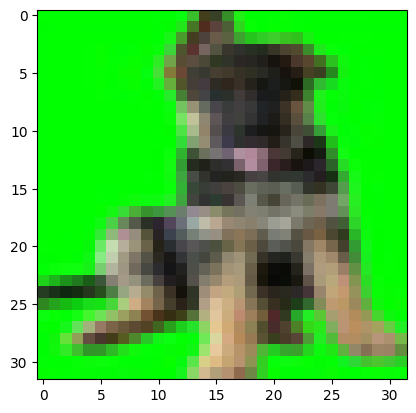

In [131]:
import matplotlib.pyplot as plt
plt.imshow(except_birds_and_planes[32097][0])

This is the image that our nn thinks is confident being a bird, it may be due to the image having vibrant color just like exotic birds due and the dog being somewhat of a bird shaped if you think about it. 